In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools as ft
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import segmentation_models as sm
import tensorflow as tf
import tensorflow.keras as keras
from preprocessing import UavidDataset

sm.set_framework("tf.keras")

tf.random.set_seed(1024)
SEED = 1024


Segmentation Models: using `keras` framework.


In [3]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]
    label = label[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release_image/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release_image/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release_image/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release_image/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds


In [4]:
def create_backbone_efficient():
    _backbone = keras.applications.EfficientNetB0(include_top=False)

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


In [5]:
class FPN(tf.keras.layers.Layer):
    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone_efficient()

        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=False)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)

        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN(backbone)
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)

        return m_all


In [6]:
class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, backbone=None, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone_efficient()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_3 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_4 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(4, 4),
            padding="same",
            activation="relu",
        )

    def call(self, images, training=False):
        conv1_o, conv2_o, conv3_o, conv4_o = self.backbone(images, training=False)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv4_o) + conv3_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv2_o
        fcn_4x = self.upscale2x_3(fcn_8x) + conv1_o
        final_output = self.upscale2x_4(fcn_4x)
        return final_output


In [7]:
class RescalingUnet(keras.layers.Layer):
    def __init__(self):
        super(RescalingUnet, self).__init__()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def call(self, inputs):
        return ((inputs * (1 / 255.0)) - self.mean) / self.std


In [8]:
def combined_model_unetfpn(mode="multiply", n_classes=8):
    model_unet = sm.Unet(
        backbone_name="efficientnetb0",
        encoder_weights="imagenet",
        encoder_freeze=False,
        classes=n_classes,
        decoder_use_batchnorm=False,
    )
    model_fpn = FCN(n_classes)

    conv1x1 = keras.layers.Conv2D(n_classes, 1, padding="same", activation="softmax")
    input_layer = keras.layers.Input([None, None, 3])
    rescale_layer = RescalingUnet()

    if mode == "concat":
        concat = keras.layers.Concatenate()

    output_model_fcn = model_unet(rescale_layer(input_layer))
    output_model_fpn = model_fpn(input_layer)

    if mode == "multiply":
        output = output_model_fcn * output_model_fpn
    elif mode == "sum":
        output = output_model_fcn + output_model_fpn
    elif mode == "concat":
        output = concat([output_model_fcn, output_model_fpn])
    else:
        raise AssertionError("mode selected is not in the list")

    output_final = conv1x1(output)

    return keras.Model([input_layer], [output_final])


In [9]:
def combined_model_fcnfpn(mode="multi", n_classes=8):
    model_fcn = FCN_ORIG(n_classes)
    model_fpn = FCN(n_classes)

    conv1x1 = keras.layers.Conv2D(n_classes, 1, padding="same", activation="softmax")

    input_layer = keras.layers.Input([None, None, 3])
    output_model_fcn = model_fcn(input_layer)
    output_model_fpn = model_fpn(input_layer)
    output = output_model_fcn * output_model_fpn
    output_final = conv1x1(output)

    return keras.Model([input_layer], [output_final])


In [10]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def jindex_per_class(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return (intersection + 1e-9) / (union + 1e-9)


In [11]:
def eval_model(model, trainds, testds):
    # evaluate on training set
    iteration = 0
    iou = tf.zeros([8])
    for bs_images, bs_label in trainds:
        output = model(bs_images, training=False)
        iou += jindex_per_class(bs_label, output)
        iteration += 1
    train_iou = iou / iteration

    # evaluate on test set
    iteration = 0
    iou = tf.zeros([8])
    for bs_images, bs_label in testds:
        output = model(bs_images, training=False)
        iou += jindex_per_class(bs_label, output)
        iteration += 1
    test_iou = iou / iteration

    print(f"Train IoU : {train_iou}")
    print(f"Test IoU : {test_iou}")

    return train_iou, test_iou


# Testing starts below


In [12]:
n_classes = 8
batch_size = 1
train_ds, test_ds = UavidDataset.create_ds(batch_size=batch_size)
iou_list = []


200


2022-12-29 20:48:05.380650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 20:48:05.395156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 20:48:05.396274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 20:48:05.400184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [13]:
####################################
# UNET(MULTIPLY) + FPN
####################################
name = "unetfpn"
model = combined_model_unetfpn()
ckpt = tf.train.Checkpoint(model=model)
ckptmg = tf.train.CheckpointManager(ckpt, f"webserver/trained_model/unetfpn", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, train_ds, test_ds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model


2022-12-29 20:48:16.960997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-12-29 20:48:19.923727: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Train IoU : [0.4030427  0.44287792 0.65816325 0.5423642  0.34652904 0.17418069
 0.7625315  0.81879914]
Test IoU : [0.32682595 0.49424347 0.59387994 0.48506144 0.31967187 0.13383238
 0.710028   0.78824425]


In [14]:
####################################
# UNET(SUM) + FPN
####################################
name = "unetfpnsum"
model = combined_model_unetfpn(mode="sum")
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/unetfpnsum", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer


KeyboardInterrupt: 

In [ ]:
####################################
# UNET(CONCAT) + FPN
####################################
name = "unetfpnconcat"
model = combined_model_unetfpn("concat")
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/unetfpnconcat", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer


In [ ]:
#####################################
# FCN + FPN
#####################################
name = "fcnfpn"
model = combined_model_fcnfpn()
optimizer = keras.optimizers.Adam(1e-5)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, f"trained_model/fcnfpn", 5)
ckptmg.restore_or_initialize()

train_iou, test_iou = eval_model(model, trainds, testds)
iou_list.append([name, train_iou, test_iou])
keras.backend.clear_session()
del model
del optimizer


In [14]:
def convert(x):
    return np.concatenate([[x[0]], x[1].numpy(), x[2].numpy()])


In [15]:
results = pd.DataFrame(
    list(map(convert, iou_list)),
    columns=[
        "model",
        "trainc1",
        "trainc2",
        "trainc3",
        "trainc4",
        "trainc5",
        "trainc6",
        "trainc7",
        "trainc8",
        "testc1",
        "testc2",
        "testc3",
        "testc4",
        "testc5",
        "testc6",
        "testc7",
        "testc8",
    ],
)

results.to_csv("results_multiple.csv")
second = results.pop("model")

results.iloc[:, 0:] = results.iloc[:, 0:].astype("float")
results["model"] = second
results


,trainc1,trainc2,trainc3,trainc4,trainc5,trainc6,trainc7,trainc8,testc1,testc2,testc3,testc4,testc5,testc6,testc7,testc8,model
0,0.403043,0.442878,0.658163,0.542364,0.346529,0.174181,0.762532,0.818799,0.326826,0.494243,0.59388,0.485061,0.319672,0.133832,0.710028,0.788244,unetfpn


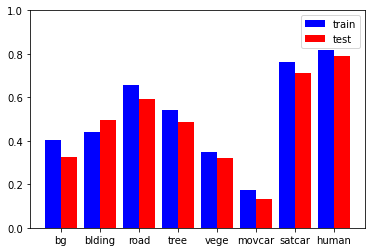

In [38]:
plt.bar(
    x=UavidDataset.labels(),
    height=results.iloc[0, 0:8],
    color="blue",
    width=-0.4,
    align="edge",
    label="train",
)

plt.bar(
    x=UavidDataset.labels(),
    height=results.iloc[0, 8:-1],
    color="red",
    width=0.4,
    align="edge",
    label="test",
)

plt.ylim([0, 1.0])
plt.legend()


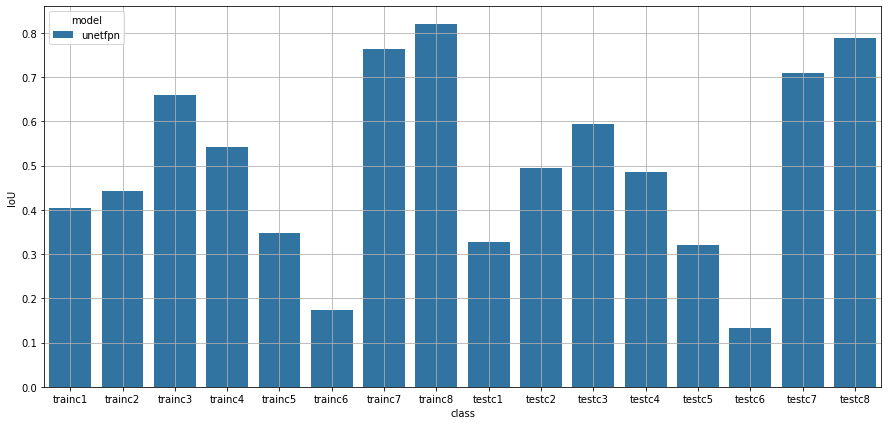

In [28]:
fg, ax = plt.subplots(figsize=(15, 7))
sb.barplot(
    data=results.melt(id_vars="model").drop_duplicates(),
    y="value",
    x="variable",
    hue="model",
    ax=ax,
)
ax.set_xlabel("class")
ax.set_ylabel("IoU")
ax.grid()
